# Membrane and Chloride-Induced Corrosion Analysis

This analysis evaluates the time to chloride-induced corrosion in bridge decks, considering:

- **Membrane Options**: No maintenance vs. with maintenance, affecting membrane service life.
- **Concrete Options**: Two concrete covers with different chloride resistance.
- **Probability of Failure**: Calculating the probability of chloride-induced corrosion, with chloride ingress dependent on membrane failure.

The goal is to determine when the probability of corrosion onset on the top rebar reaches 50%.


In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import relevant modules from rational_rc package
from rational_rc.membrane import MembraneModel  # Membrane life model
from rational_rc.chloride import (
    ChlorideModel,  # Chloride diffusion model class
    load_df_D_RCM,  # Function to load chloride diffusion coefficients
    C_crit_param,   # Critical chloride concentration parameters
    C_eqv_to_C_S_0  # Function to calculate equivalent surface chloride concentration
)
import rational_rc.math_helper as mh  # Math helper functions

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')



# Membrane breakdown

In [2]:
# Case Study - Global Parameters

# Create a generic parameter class to store parameters
class Param: pass

# Initialize membrane parameters
pars_mem = Param()

# Membrane service life parameters
pars_mem.life_product_label_life = 10  # Membrane life (years) with 95% confidence (non-failure)
pars_mem.life_std = 0.2 * pars_mem.life_product_label_life  # Standard deviation, assumed at 20% of the product life
pars_mem.life_confidence = 0.95  # Confidence level for the membrane service life


In [3]:
# Initialize and Run Membrane Models

# Initialize membrane model for "with maintenance" scenario
mem_model_with_main = MembraneModel(pars_mem)

# Create a copy of the model for "no maintenance" scenario
mem_model_no_main = mem_model_with_main.copy()

# Override with known values for membrane life

# No maintenance scenario
mem_model_no_main.pars.life_mean = 12.5  # Mean service life (years)
mem_model_no_main.pars.life_std = 2.5    # Standard deviation of service life (years)

# With maintenance scenario
mem_model_with_main.pars.life_mean = 35  # Mean service life (years)
mem_model_with_main.pars.life_std = 5    # Standard deviation of service life (years)

# Run the membrane model for "no maintenance" scenario for 10 years
mem_model_no_main.run(10)

# Post-process results for the "no maintenance" model (plotting disabled)
mem_model_no_main.postproc(plot=False)


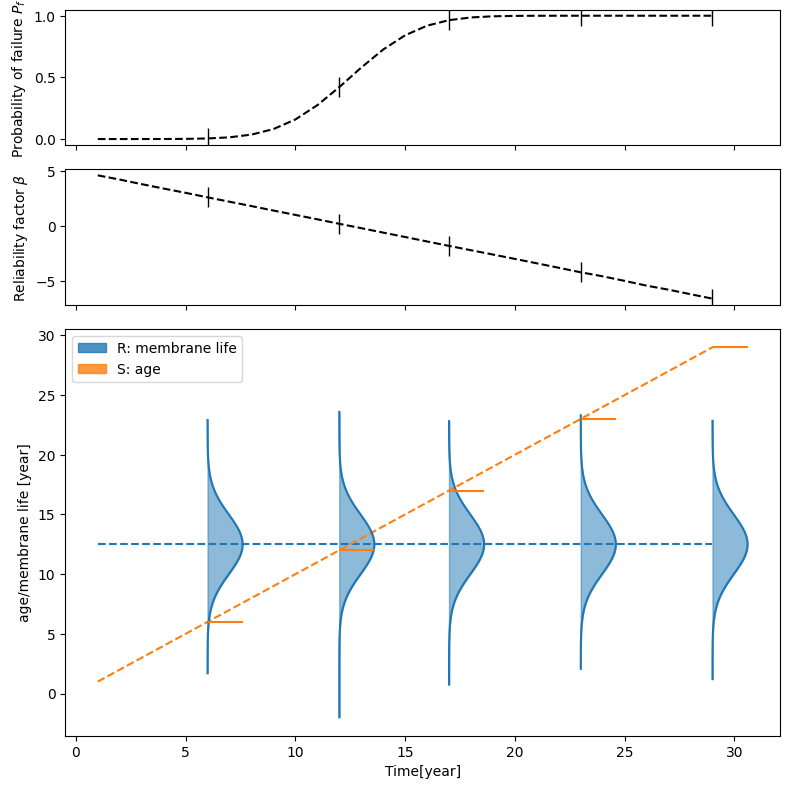

In [4]:
# Simulate Membrane Failure over Time (No Maintenance)

# Define the list of years for the simulation
year_lis = np.arange(1, 30, 1)  # Simulate from year 1 to 29

# Run the membrane failure model for each year in the list
# 'amplify' adjusts the scaling of the probability density function (PDF) for better visualization
pf_mem, beta_mem = mem_model_no_main.membrane_failure_with_year(year_lis, amplify=10, plot=True)

# Optionally, save the plot (disabled for now)
# plt.savefig('plots/membrane_year.pdf', dpi=600)


In [5]:
# Store Results in a Pandas DataFrame and Save to Disk

# Create a DataFrame to store the year, probability of failure (pf), and reliability index (beta)
df_mem = pd.DataFrame({
    'year': year_lis,   # List of years
    'pf': pf_mem,       # Probability of membrane failure
    'beta': beta_mem    # Reliability index (beta)
})

# Optionally, save the DataFrame to a CSV file (disabled for now)
# df_mem.to_csv("tables/membrane_year.csv", index=None)


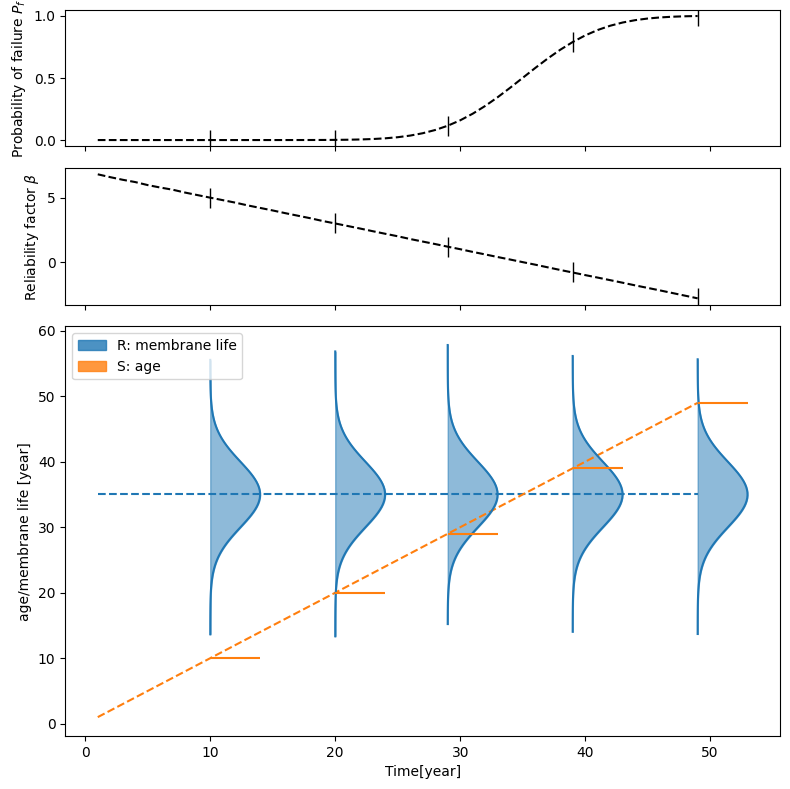

In [6]:
# Simulate Membrane Failure over Time (With Maintenance)

# Define the list of years for the simulation (with maintenance)
year_lis_main = np.arange(1, 50, 1)  # Simulate from year 1 to 49

# Run the membrane failure model for the "with maintenance" scenario
# 'amplify' scales the probability density function (PDF) for better visualization
pf_mem_main, beta_mem_main = mem_model_with_main.membrane_failure_with_year(year_lis_main, amplify=50, plot=True)

# Optionally, save the plot (currently disabled)
# plt.savefig('plots/membrane_main_year.pdf', dpi=600)


In [7]:
# Store Results in a Pandas DataFrame and Save to Disk (With Maintenance Scenario)

# Create a DataFrame to store the year, probability of failure (pf), and reliability index (beta)
df_mem_main = pd.DataFrame({
    'year': year_lis_main,  # List of years for the "with maintenance" scenario
    'pf': pf_mem_main,      # Probability of membrane failure
    'beta': beta_mem_main   # Reliability index (beta)
})

# Optionally, save the DataFrame to a CSV file (currently disabled)
# df_mem_main.to_csv("tables/membrane_main_year.csv", index=None)


# Chloride transport

In [8]:
# Example of Diffusivity reported from Rapid chloride Migration Test
load_df_D_RCM()

,CEM_I_42.5_R,CEM_I_42.5_R+FA,CEM_I_42.5_R+SF,CEM_III/B_42.5
wc_eqv,,,,
0.35,NaN,NaN,4.4,NaN
0.40,8.9,5.6,4.8,8.3
0.45,10.0,6.9,NaN,1.9
0.50,15.8,9.0,NaN,2.8
0.55,17.9,10.9,5.3,3.0
0.60,25.0,14.9,NaN,3.4


In [9]:
pars_cl = Param()

pars_cl.marine = True

# 1)marine or coastal
pars_cl.marine = False # True, if it is marine or coastal environment
pars_cl.C_0_M = 18.980  # natural chloirde content of sea water [g/l] https://www.lenntech.com/composition-seawater.htm

# 2) de icing salt (hard to quantify, set to zero for now then overwrite the advection zone and boundary chloride content)
pars_cl.C_0_R = 0  # average chloride content of the chloride contaminated water [g/l]
pars_cl.n = 0      # average number of salting events per year [-]
pars_cl.C_R_i = 0  # average amount of chloride spread within one spreading event [g/m2]
pars_cl.h_S_i = 1  # amount of water from rain and melted snow per spreading period [l/m2]

pars_cl.exposure_condition = 'splash'   # Splash zone exposure, will be overwritten later


pars_cl.T_real = 273 + 25  # Real temperature in Kelvin (assumed 25°C)

pars_cl.D_RCM_test = 'N/A'  # No specific Rapid Chloride Migration (RCM) test data
pars_cl.concrete_type = 'Portland cement concrete'
pars_cl.cement_concrete_ratio = 300. / 2400.  # Cement content to concrete ratio
pars_cl.C_0 = 0  # Initial chloride content in concrete

# Critical chloride concentration distribution parameters
pars_cl.C_crit_distrib_param = C_crit_param()

# Options for chloride diffusion modeling
pars_cl.option = Param()
pars_cl.option.choose = True  # Enable option selection
pars_cl.option.cement_type = 'CEM_I_42.5_R'  # Cement type
pars_cl.option.wc_eqv = 0.4  # Water-cement ratio (equivalent)
pars_cl.option.df_D_RCM_0 = load_df_D_RCM()  # Load diffusivity coefficients from RCM tests
pars_cl.exposure_condition_geom_sensitive = False  # Geometry-sensitive exposure condition (set to False)
pars_cl.C_eqv_to_C_S_0 = C_eqv_to_C_S_0

# Cover depth for chloride diffusion (normally distributed)
cover_depth = mh.normal_custom(70, 10, non_negative=True)  # Cover depth in mm (mean = 70 mm, std dev = 10 mm)


Pf(g = R-S < 0) from various methods
    sample count: 0.32978
    g integral: 0.3306601733583403
    R S integral: 0.3307812810784724
    beta_factor: 0.3486954367821007
0.13893412765728455 0.727126581069722


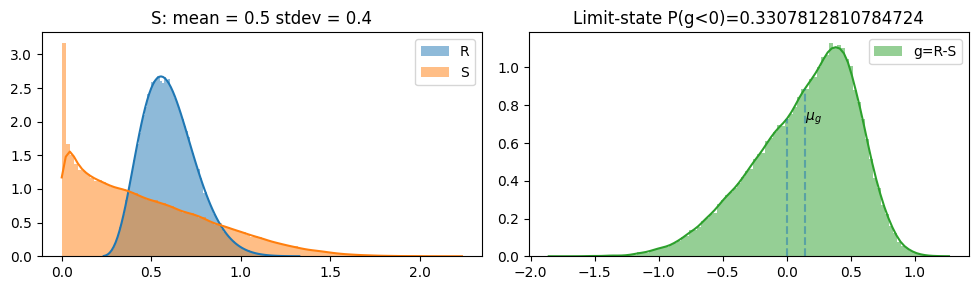

In [10]:
# Run Chloride Diffusion Model at t = 10 years

# Initialize the chloride diffusion model using the defined parameters
cl_model = ChlorideModel(pars_cl)

# Overwrite surface chloride concentration (C_S_dx) and advection zone thickness (dx)
cl_model.pars.C_S_dx = 0.409 / pars_cl.cement_concrete_ratio  # Surface chloride concentration adjusted for cement/concrete ratio
cl_model.pars.dx = 5  # Advection zone thickness in mm

# Run the chloride diffusion model at time t = 10 years and for the given cover depth
cl_model.run(x=cover_depth, t=10)

# Post-process the results and generate a plot
cl_model.postproc(plot=True)


In [11]:
# Simulate Chloride Ingress Over Time

# Define the list of years for the simulation (1 to 99 years)
year_lis_cl = np.arange(1, 100, 1)

# Run the chloride ingress model for each year in the list
# 'amplify' scales the probability density function (PDF) for better visualization (set to 4 here)
pf_cl, beta_cl = cl_model.chloride_with_year(depth=cover_depth, year_lis=year_lis_cl, amplify=4, plot=False)

# Optionally, save the plot (currently disabled)
# plt.savefig('plots/chloride_year.pdf', dpi=600)


In [12]:
# Store Chloride Ingress Results in a Pandas DataFrame and Save to Disk

# Create a DataFrame to store the year, probability of failure (pf), and reliability index (beta)
df_cl = pd.DataFrame({
    'year': year_lis_cl,  # List of years for chloride ingress simulation
    'pf': pf_cl,          # Probability of chloride-induced failure
    'beta': beta_cl       # Reliability index (beta)
})

# Optionally, save the DataFrame to a CSV file (currently disabled)
# df_cl.to_csv("tables/chloride_year_wc04_cem.csv", index=None)


In [13]:
# Chloride Ingress Simulation with 0.35 Water-Cement Ratio and Silica Fume (SF)

# Create a copy of the original chloride model and modify for silica fume (SF) addition
cl_model_SF = cl_model.copy()
cl_model_SF.pars.option.cement_type = 'CEM_I_42.5_R+SF'  # Cement type with silica fume
cl_model_SF.pars.option.wc_eqv = 0.35  # Water-cement ratio equivalent set to 0.35

# Run chloride ingress simulation with the modified model
pf_cl_SF, beta_cl_SF = cl_model_SF.chloride_with_year(depth=cover_depth, year_lis=year_lis_cl, amplify=4, plot=False)

# Store the results in a DataFrame
df_cl_SF = pd.DataFrame({
    'year': year_lis_cl,  # List of years
    'pf': pf_cl_SF,       # Probability of chloride-induced failure with SF
    'beta': beta_cl_SF    # Reliability index (beta) with SF
})

# Optionally, save the DataFrame to a CSV file (currently disabled)
# df_cl_SF.to_csv("tables/chloride_year_wc04_cem_SF.csv", index=None)


# Combined Probability of Chloride-Induced Corrosion at Time t

Now that we have the probability of membrane breakdown (P_f_mem) over time, we can combine it with the chloride diffusion process.

At each historical time step t_i (t_i < t):
- Chloride diffusion begins with an incremental probability ΔP_f_mem(t_i).
- For each subsequent time step (t - t_i), chloride diffusion continues with a probability P_f_cl(t - t_i) of reaching the critical chloride concentration.

By summing over all time steps, we calculate the combined probability of chloride-induced corrosion, considering both membrane breakdown and chloride diffusion.

### Pseudo-code:

1. Define the list of time steps: t_list
2. Compute incremental probability of membrane failure: ΔP_f_mem = diff(P_f_mem)
3. For each year t:
   - Compute: 1 - product of [1 - ΔP_f_mem(t_i) * P_f_chloride(t - t_i)] for all time steps t_i from 0 up to year t

The final result will be the propogated probability of chloride-induced corrosion over time.


In [14]:
def pf_mem_cl(t, pf_membrane_t_curve, pf_cl_t_curve):
    """
    Calculate the propagated total probability of membrane failure and chloride-induced corrosion.

    Args:
    t : array-like
        List of time steps (years).
    pf_membrane_t_curve : tuple
        Interpolation curve for membrane failure probability (t_lis, pf_lis).
    pf_cl_t_curve : tuple
        Interpolation curve for chloride-induced corrosion (x_loss_array, p_surface_crack_array).
    
    Returns:
    pf_mem_cl_t : numpy array
        Propagated total probability of membrane failure and chloride-induced corrosion at each time step.
    """
    
    # Initialize list to store combined probability results over time
    pf_mem_cl_t = []

    # Unpack the membrane failure and chloride failure curves
    t_mem, pf_mem = pf_membrane_t_curve
    t_cl, pf_cl = pf_cl_t_curve

    for ti in t:
        # Get time steps up to the current year (ti)
        t_lis = t[0 : np.where(t == ti)[0][0] + 1]
        age_lis = ti - t  # Calculate duration
        age_lis = age_lis[age_lis >= 0]  # Consider only positive durations

        # Interpolate membrane failure probability at each age step
        pf_mem_lis = np.interp(
            age_lis, t_mem, pf_mem, left=pf_mem.min(), right=pf_mem.max()
        )

        # Interpolate chloride-induced failure probability at each age step
        pf_cl_lis = np.interp(
            age_lis, t_cl, pf_cl, left=pf_cl.min(), right=pf_cl.max()
        )

        # Compute the incremental membrane failure probability
        pf_mem_increment = np.diff(pf_mem_lis, prepend=0)

        # Compute the combined probability of membrane failure and chloride-induced corrosion
        pf_mem_cl_t.append(1 - np.prod(1 - pf_cl_lis * pf_mem_increment))

    return np.array(pf_mem_cl_t)


In [15]:
# Time range for the simulation (0 to 300.5 years, with a step of 0.5 years)
t = np.arange(0, 150.5, 0.5)

# Combine membrane and chloride failure probabilities for w/c = 0.4
pf_mem_cl_t = pf_mem_cl(
    t,
    pf_membrane_t_curve=(year_lis, pf_mem),  # Membrane without maintenance
    pf_cl_t_curve=(year_lis_cl, pf_cl)       # Chloride diffusion w/c = 0.4
)

pf_mem_main_cl_t = pf_mem_cl(
    t,
    pf_membrane_t_curve=(year_lis_main, pf_mem_main),  # Membrane with maintenance
    pf_cl_t_curve=(year_lis_cl, pf_cl)                 # Chloride diffusion w/c = 0.4
)

# Combine membrane and chloride failure probabilities for w/c equivalent = 0.35 with silica fume (SF)
pf_mem_cl_t_SF = pf_mem_cl(
    t,
    pf_membrane_t_curve=(year_lis, pf_mem),  # Membrane without maintenance
    pf_cl_t_curve=(year_lis_cl, pf_cl_SF)    # Chloride diffusion w/c = 0.35 with SF
)

pf_mem_main_cl_t_SF = pf_mem_cl(
    t,
    pf_membrane_t_curve=(year_lis_main, pf_mem_main),  # Membrane with maintenance
    pf_cl_t_curve=(year_lis_cl, pf_cl_SF)              # Chloride diffusion w/c = 0.35 with SF
)

# Create a DataFrame to store results for membrane and chloride failure probabilities
df_membrane_and_chloride = pd.DataFrame({
    'year': t, 
    'membrane': np.interp(t, year_lis, pf_mem, left=pf_mem.min(), right=pf_mem.max()),
    'chloride_wc_0.4': np.interp(t, year_lis_cl, pf_cl, left=pf_cl.min(), right=pf_cl.max()),
    'chloride_wc_0.35_SF': np.interp(t, year_lis_cl, pf_cl_SF, left=pf_cl_SF.min(), right=pf_cl_SF.max()),
    'membrane + chloride_wc_0.4': pf_mem_cl_t,
    'membrane with maintenance + chloride_wc_0.4': pf_mem_main_cl_t,
    'membrane + chloride_wc_0.35_SF': pf_mem_cl_t_SF,
    'membrane with maintenance + chloride_wc_0.35_SF': pf_mem_main_cl_t_SF
})

# Optionally save the DataFrame to a CSV file (currently disabled)
# df_membrane_and_chloride.to_csv("plots/pf_membrane_and_chloride_plot_data.csv", index=None)


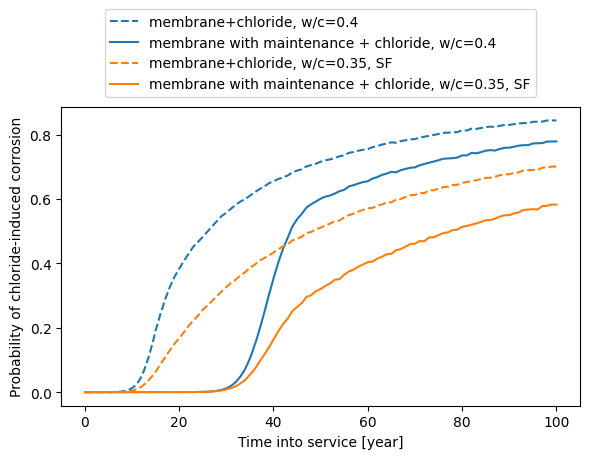

In [16]:
# Plot the combined probability of membrane breakdown and chloride-induced corrosion

# Define time range for plotting
t_range = (0, 100)
mask = df_membrane_and_chloride['year'] <= t_range[1]  # Mask to filter years up to 100

plt.figure(figsize=(6,5))
plt.plot(
    df_membrane_and_chloride.loc[mask,'year'], 
    df_membrane_and_chloride.loc[mask,'membrane + chloride_wc_0.4'],
    '--',
    color = 'C0',
    label='membrane+chloride, w/c=0.4'
)
plt.plot(
    df_membrane_and_chloride.loc[mask,'year'], 
    df_membrane_and_chloride.loc[mask,'membrane with maintenance + chloride_wc_0.4'],
    color = 'C0',
    label='membrane with maintenance + chloride, w/c=0.4'
)
plt.plot(
    df_membrane_and_chloride.loc[mask,'year'], 
    df_membrane_and_chloride.loc[mask,'membrane + chloride_wc_0.35_SF'],
    '--',
    color = 'C1',
    label='membrane+chloride, w/c=0.35, SF'
)
plt.plot(
    df_membrane_and_chloride.loc[mask,'year'], 
    df_membrane_and_chloride.loc[mask,'membrane with maintenance + chloride_wc_0.35_SF'],
    color = 'C1',
    label='membrane with maintenance + chloride, w/c=0.35, SF'
)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=1, fancybox=True, shadow=False)

plt.xlabel('Time into service [year]')
plt.ylabel('Probability of chloride-induced corrosion')
plt.tight_layout()

# Optionally save the plot (currently disabled)
# plt.savefig('plots/pf_chloride_induced_corrosion_all.pdf', dpi=600)
